# 랜덤포레스트


전자상거래 소매업체는 기계 학습을 사용하여 디지털 아울렛(웹 사이트 및 앱)에 대한 고객의 온라인 참여를 이해하려고 합니다. 이 회사는 모바일 앱의 경험과 웹사이트 중 어느 것에 집중할지 결정하려고 한다. 선형 회귀 모델을 사용하여 어떤 사용자의 활동이 더 많은 돈을 사용할 가능성에 가장 큰 영향을 미치는지 확인합니다.

#### 대상 변수 :
평균 세션 길이: 매장 스타일의 조언 세션의 평균 세션 시간. <br>
앱 사용 시간: 앱 평균 사용 시간(분) <br>
웹 사이트 체류 시간: 웹 사이트에 소요된 평균 시간(분) <br>
회원 기간: 고객이 회원이 된 이후의 연수 <br>

### 필요한 패키지(Snowpark 포함) 가져오기
Python 환경에 패키지가 없으면 conda를 사용하여 설치할 수 있습니다. Seaborn 시각화 패키지의 설치 예는 다음과 같습니다.

* import sys <br>
!conda install --yes --prefix {sys.prefix} seaborn*

In [1]:
# Snowpark
import json

# Plotting
import matplotlib.pyplot as plt
import numpy as np
# Pandas & json
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
# Models
from sklearn.model_selection import train_test_split
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import pandas_udf
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION

%matplotlib inline

### Set context

In [2]:
# Read credentials
with open('connection.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [3]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "SNOW_ML"
Schema                      : "PUBLIC"
Warehouse                   : "COMPUTE_WH"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 0.11.0


### Data Loading

In [5]:
customers = pd.read_csv("EcommerceCustomers.csv")
customers.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [6]:
# Create a Snowpark DF from the pandas DF
snowdf = session.createDataFrame(customers)

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


In [7]:
snowdf.show(2)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Email"                    |"Address"                   |"Avatar"   |"Avg. Session Length"  |"Time on App"       |"Time on Website"   |"Length of Membership"  |"Yearly Amount Spent"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mstephenson@fernandez.com  |835 Frank Tunnel            |Violet     |34.49726772511229      |12.655651149166752  |39.57766801952616   |4.082620632952961       |587.9510539684005      |
|                           |Wrightmouth, MI 82180-9605  |           |                       |                    |                    |                        |                       |
|hduke@hotmail.com          |4547 Archer Common          |DarkGreen  |

In [16]:
# Loading customer data from Snowpark DF to a Snowflake internal table

snowdf.write.mode("overwrite").saveAsTable("customers_new") 

session.table("CUSTOMERS_NEW").limit(3).show(5)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Email"                    |"Address"                       |"Avatar"   |"Avg. Session Length"  |"Time on App"       |"Time on Website"   |"Length of Membership"  |"Yearly Amount Spent"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mstephenson@fernandez.com  |835 Frank Tunnel                |Violet     |34.49726772511229      |12.655651149166752  |39.57766801952616   |4.082620632952961       |587.9510539684005      |
|                           |Wrightmouth, MI 82180-9605      |           |                       |                    |                    |                        |                       |
|hduke@hotmail.com          |4547 Archer Common   

In [17]:
# Create a pandas data frame from the Snowflake table
custdf = session.table('CUSTOMERS_NEW').toPandas() 

print(f"'custdf' local dataframe created. Number of records: {len(custdf)} ")

'custdf' local dataframe created. Number of records: 500 


### Model Training & Testing

#### 모델스테이지 생성

In [18]:
session.sql("CREATE STAGE IF NOT EXISTS PCS_models").collect()

[Row(status='PCS_MODELS already exists, statement succeeded.')]

In [19]:
# Define X and Y for modeling
X = custdf[['Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership']]
Y = custdf['Yearly Amount Spent']

In [20]:
# Split into training & Testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                 test_size=0.3, random_state=101)

#### Linear Regression - Predict Yearly Spend

In [21]:
# Create an instance of Linear Regression and Fit the training datasets
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [22]:
import joblib

joblib.dump(rf,"prc_model.joblib")

['prc_model.joblib']

In [23]:
session.file.put("prc_model.joblib", "@PCS_models", auto_compress=True, overwrite=True)

[PutResult(source='prc_model.joblib', target='prc_model.joblib.gz', source_size=2843131, target_size=724848, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [24]:
# Creating a User Defined Function within Snowflake to do the scoring there
def predict_pandas_udf(df: pd.DataFrame) -> pd.Series:
    return pd.Series(rf.predict(df))  

linear_model_vec = pandas_udf(func=predict_pandas_udf,
                                return_type=FloatType(),
                                input_types=[FloatType(),FloatType(),FloatType(),FloatType()],
                                session=session,
                                packages = ("pandas","scikit-learn"), max_batch_size=200)

In [28]:
# Calling the UDF to do the scoring (pushing down to Snowflake)
output = session.table('CUSTOMERS_NEW').select(*list(X.columns),
                    linear_model_vec(list(X.columns)).alias('PREDICTED_SPEND'), 
                    (F.col('Yearly Amount Spent')).alias('ACTUAL_SPEND')
                    )

output.show(5)

--------------------------------------------------------------------------------------------------------------------------------------
|"Avg. Session Length"  |"Time on App"       |"Time on Website"   |"Length of Membership"  |"PREDICTED_SPEND"   |"ACTUAL_SPEND"      |
--------------------------------------------------------------------------------------------------------------------------------------
|34.49726772511229      |12.655651149166752  |39.57766801952616   |4.082620632952961       |586.7132416410486   |587.9510539684005   |
|31.92627202636016      |11.109460728682564  |37.268958868297744  |2.66403418213262        |393.03536133197815  |392.2049334443264   |
|33.000914755642675     |11.330278057777512  |37.11059744212085   |4.104543202376424       |510.7240585737829   |487.54750486747207  |
|34.30555662975554      |13.717513665142508  |36.72128267790313   |3.120178782748092       |571.9269891575096   |581.8523440352178   |
|33.33067252364639      |12.795188551078114  |37.536653

In [29]:
# Save the predicted output as a table on Snowflake
###used later in Streamlit app
output.write.mode("overwrite").saveAsTable("PREDICTED_CUSTOMER_SPEND") 

# Also get a local dataframe to review the results
output=output.toPandas()

##### Plotting and comparing the predicted values with actual spend values

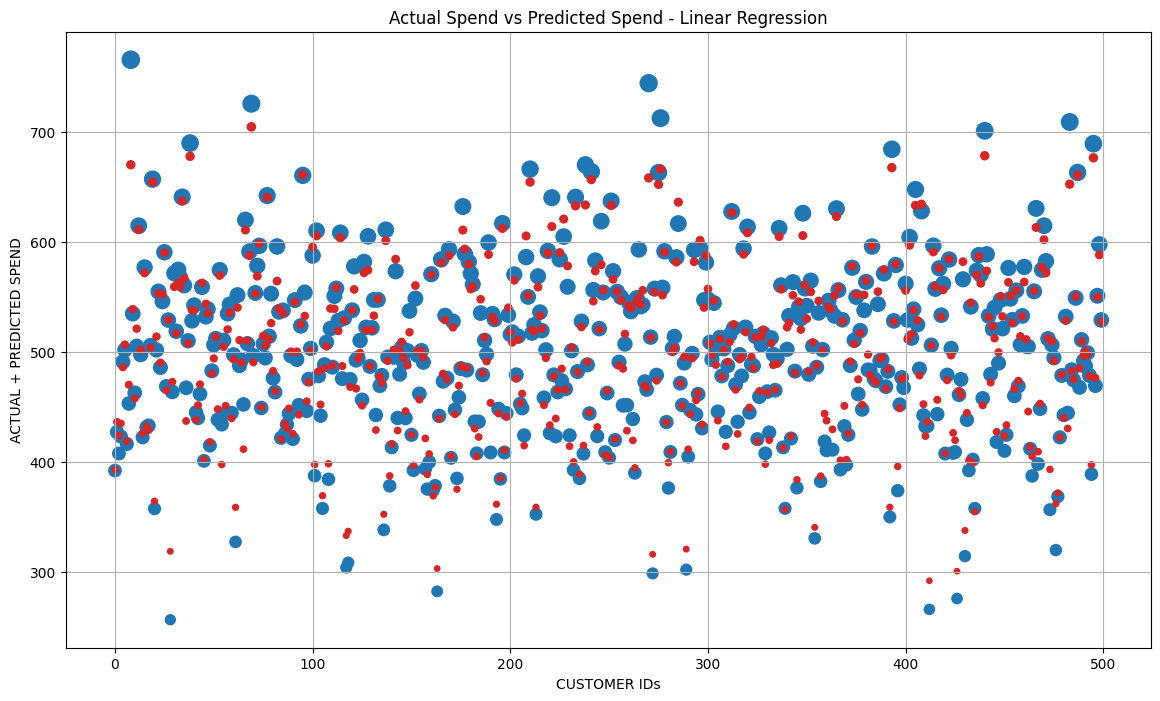

In [30]:
# Plot a descriptive scatter of predicted and actual values
x = output.index
y1 = output["ACTUAL_SPEND"]
y2 = output["PREDICTED_SPEND"]

f, ax = plt.subplots(figsize=(14, 8))
plt.scatter(x, y1, c='tab:blue', s=y1/5)
plt.scatter(x, y2, c='tab:red', s=y2/20)

plt.title(f"Actual Spend vs Predicted Spend - Linear Regression")
plt.ylabel("ACTUAL + PREDICTED SPEND")
plt.xlabel("CUSTOMER IDs")
ax.grid(True)
plt.show()

*To start with, define a function for regression metrics*

1. R² measures how much variability in dependent variable can be "explained by the model.
2. While R² is a relative measure of how well the model fits dependent variables, Mean Square Error is an absolute measure of the goodness for the fit.
3. Mean Absolute Error(MAE) is similar to MSE, however, unlike MSE, MAE takes the sum of the ABSOLUTE value of error.

*[Regression Merics Reference](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914)*

In [31]:
#1 & 2 Coefficient of Determination (R² & Adjusted R²)
print("\n--- Coefficient of Determination (R²) ---")
r2 = metrics.r2_score(y_pred=y2, y_true=y1)
print(f"R²: {round(r2, 2)}")


#5. MAE
print("\n--- Mean Absolute Error (MAE) ---")
mae = metrics.mean_absolute_error(y_pred=y2, y_true=y1)
print(f"MAE: {round(mae, 2)}")


--- Coefficient of Determination (R²) ---
R²: 0.97

--- Mean Absolute Error (MAE) ---
MAE: 8.4


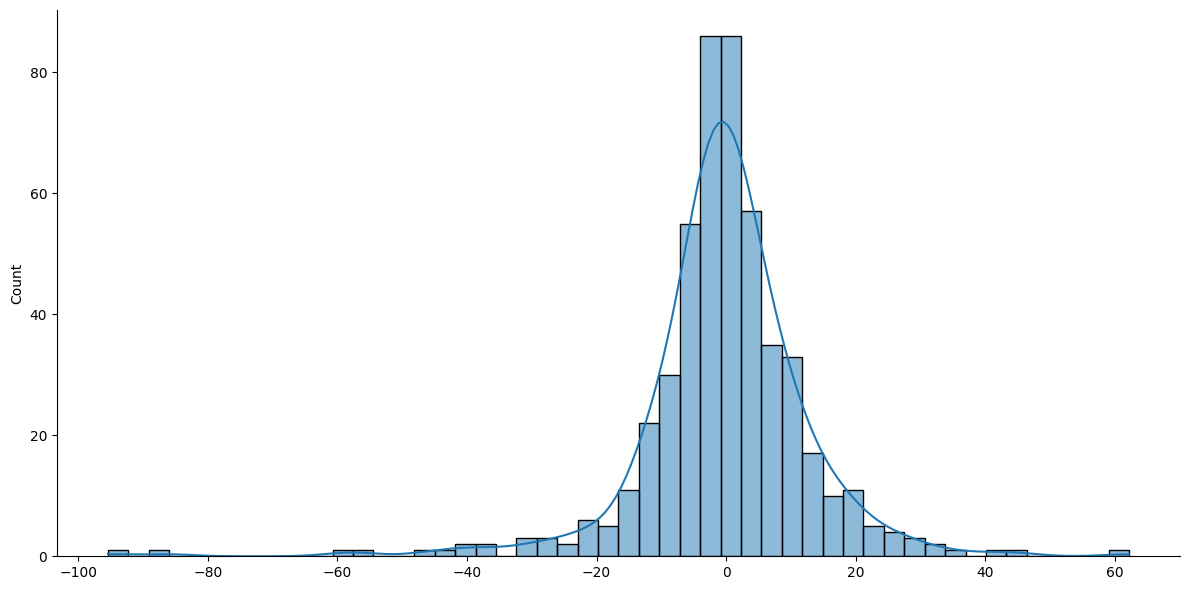

In [32]:
# Distribution of differences between actual and predicted values
# Gaussian kernel density estimate.

sns.displot((y2-y1),bins=50, kde=True, legend=True, height=6, aspect=2);

In [33]:
# Get coefficients from the fitted model
coeff_df = pd.DataFrame(rf.feature_importances_,X.columns,columns=['Feature Importance']).round(2)
coeff_df

,Feature Importance
Avg. Session Length,0.10
Time on App,0.21
Time on Website,0.01
Length of Membership,0.68


In [34]:
session.createDataFrame(coeff_df).show()

c:\users\dksystems\anaconda3\envs\nlp_ml_sentiment_analysis\lib\site-packages\snowflake\snowpark\session.py:1165: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.base.Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


------------------------
|"Feature Importance"  |
------------------------
|0.1                   |
|0.21                  |
|0.01                  |
|0.68                  |
------------------------



### Conclusion
Time spent on the app and Length of Membership are most important factors driving customer spend. The retailer should focus its efforts on increasing stickiness to its app and enhance its loyalty programs.